# Figure 4

This notebook is used to reproduce Figure 4 of [PHYSICAL REVIEW B 98, 094104 (2018)](https://doi.org/10.1103/PhysRevB.98.094104).

* Author: Xin Chen
* Email: Bismarrck@me.com

In [1]:
import numpy as np
import ase

from ase.build import bulk
from ase import Atoms
from ase import units
from tensoralloy.calculator import TensorAlloyCalculator
from pymatgen import Lattice, Structure
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

## 1. Conventional fcc Ni

First, we should create a base fcc/cubic Ni structure.

**Note**: the conventional structure defined in this [tutorial](https://matgenb.materialsvirtuallab.org/2017/04/03/Slab-generation-and-Wulff-shape.html) is wrong!

In [2]:
lattice = Lattice.cubic(3.52)
base_structure = Structure(
    lattice, 
    ["Ni", "Ni", "Ni", "Ni"],
    [[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], 
     [0.5, 0.0, 0.5], [0.5, 0.5, 0.0]])

## 2. Slabs

Create different Ni surface structures from `base_structure`.

In [3]:
miller_indices = [
    [1, 0, 0], [1, 1, 0], [1, 1, 1], [2, 1, 0],
    [2, 1, 1], [2, 2, 1], [3, 1, 0], [3, 1, 1], 
    [3, 2, 0], [3, 2, 1], [3, 2, 2], [3, 3, 1],
    [3, 3, 2], [4, 1, 1], [4, 2, 1], [4, 3, 1], 
    [4, 3, 2], [4, 3, 3], [4, 4, 1], [4, 4, 3],
]
structures = {}

for miller_index in miller_indices:
    key = "".join(map(str, miller_index))
    slabgen = SlabGenerator(base_structure, miller_index, min_slab_size=10, min_vacuum_size=10)
    all_slabs = slabgen.get_slabs()
    if len(all_slabs) > 1:
        print(f"Warning: more than one slabs generated for {key}")
    slab = all_slabs[0]
    assert slab.miller_index == tuple(miller_index)
    slab.make_supercell([4, 4, 1])
    structures[key] = slab

## 3. Results

### 3.1 Calculators

Load calculators:

* `zjw04`: The original Zjw04 EAM calculator
* `zjw04xc`: The machine-learning optimized continous Zjw04 EAM calcualtor
* `behler`: The Behler's symmetry function based atomistic neural network calculator

In [4]:
zjw04 = TensorAlloyCalculator('Ni.zjw04.pb')
zjw04xc = TensorAlloyCalculator('Ni.zjw04xc.pb')
behler = TensorAlloyCalculator('Ni.behler.k2.pb')

Compute the potential energy of the bulk Ni.

In [5]:
bulk_atoms = bulk('Ni')
ref = {
    'zjw04': zjw04.get_potential_energy(bulk_atoms),
    'zjw04xc': zjw04xc.get_potential_energy(bulk_atoms),
    'behler': behler.get_potential_energy(bulk_atoms)
}

### 3.2 Unit Convention Factor

The desired unit is $J/m^2$.

In [6]:
factor = units.eV / units.Angstrom**2 / (units.J / units.m**2)

### 3.3 Surface Energy

Define a helper function:

In [7]:
def calculate(calc: TensorAlloyCalculator, atoms: Atoms, bulk_energy: float, area: float):
    """
    Return the surface energy (J/m**2).
    """
    n = len(atoms)
    surface_energy = calc.get_potential_energy(atoms)
    return (surface_energy - bulk_energy * n) / area / 2.0 * factor

Compute the surface energies using calcualtors above.

In [8]:
surface_energies = {
    'zjw04': [], 
    'zjw04xc': [],
    'behler': [],
}

for miller_index in miller_indices:
    key = "".join(map(str, miller_index))
    slab = structures[key]
    area = slab.surface_area
    atoms = AseAtomsAdaptor.get_atoms(slab)
    surface_energies['zjw04'].append(calculate(zjw04, atoms, ref['zjw04'], area))
    surface_energies['zjw04xc'].append(calculate(zjw04xc, atoms, ref['zjw04xc'], area))
    surface_energies['behler'].append(calculate(behler, atoms, ref['behler'], area))

### 3.4 DFT

DFT results are picked from the original figure.

In [9]:
dft = [
    # These values are picked from the tutorial mentioned above.
    2.2084, # (1, 0, 0)
    2.2862, # (1, 1, 0)
    1.9235, # (1, 1, 1)
    2.3969, # (2, 1, 0)
    2.2353, # (2, 1, 1)
    2.1732, # (2, 2, 1)
    2.3964, # (3, 1, 0)
    2.3039, # (3, 1, 1)
    2.3869, # (3, 2, 0)
    2.3183, # (3, 2, 1)
    2.1242, # (3, 2, 2)
    2.2288, # (3, 3, 1)
    2.0944, # (3, 3, 2)
    # These are approximated values
    (964 - 569) / (964 - 669) * 0.9 + 1.1, # (4, 1, 1)
    (964 - 553) / (964 - 669) * 0.9 + 1.1, # (4, 2, 1)
    (964 - 561) / (964 - 669) * 0.9 + 1.1, # (4, 3, 1)
    (964 - 596) / (964 - 669) * 0.9 + 1.1, # (4, 3, 2)
    (964 - 644) / (964 - 669) * 0.9 + 1.1, # (4, 3, 3)
    (964 - 588) / (964 - 669) * 0.9 + 1.1, # (4, 4, 1)
    (964 - 653) / (964 - 669) * 0.9 + 1.1, # (4, 4, 3)
]
surface_energies['dft'] = dft

## 4. Plot

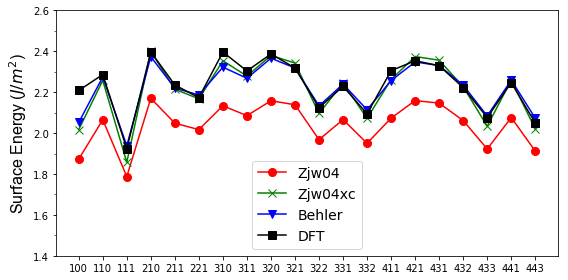

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[8, 4])

h1, = ax.plot(surface_energies['zjw04'], 'r.-', markersize=16)
h2, = ax.plot(surface_energies['zjw04xc'], 'gx-', markersize=8)
h3, = ax.plot(surface_energies['behler'], 'bv-', markersize=8)
h4, = ax.plot(surface_energies['dft'], 's-', markersize=8, color='black')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([""] + ["".join(map(str, miller_index)) for miller_index in miller_indices])

ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel(r"Surface Energy ($J/m^2$)", fontsize=16, fontname='arial')

ax.set_ylim([1.4, 2.6])

plt.legend([h1, h2, h3, h4], ['Zjw04', 'Zjw04xc', 'Behler', 'DFT'], fontsize=14, loc='lower center')

plt.tight_layout()
plt.savefig('fig4.png', dpi=300)
plt.show()